In [1]:
%%capture

%cd ..
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from unidecode import unidecode
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

pd.set_option('expand_frame_repr', True)
pd.set_option('display.column_space', 6)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.show_dimensions', True)

# Data Cleaning

This notebook will be used to clean the data loaded on the previous step *2 - Data Preparation.ipynb". Here we are going to do some text preprocessing, general cleaning, missing values analysis and we are going to also look for outliers. First, let's load the data

In [53]:
DATA_PATH = Path('data/interim/') 
REPORTS_PATH = Path("reports/figures")
SAVE_FIGURES = True

In [4]:
data_df = pd.read_csv(DATA_PATH / 'fake_true_news.csv')
data_df.head()

,class,file_index,text,author,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity
0,True,1,﻿O Podemos decid...,Naira Trindade,http://politica....,politica,13/12/2017,168.0,148.0,107.0,NaN,0.0,24.0,2.0,43.0,5.0,4.0,3.0,0.0,0.0,7.0,3.33333,761.0,24.6667,5.14189,0.000000,0.134328,0.72297
1,True,10,Bolsonaro é um l...,Marco Rodrigo Al...,http://www1.folh...,politica,12/1/2018,1028.0,865.0,474.0,NaN,9.0,135.0,2.0,237.0,56.0,45.0,14.0,3.0,1.0,63.0,2.85965,4205.0,15.1754,4.86127,0.001156,0.271505,0.54797
2,True,100,Ministro do STF ...,"Fernando Zuba , ...",https://g1.globo...,politica,7/12/2017,540.0,476.0,232.0,NaN,8.0,69.0,0.0,146.0,10.0,20.0,7.0,0.0,0.0,19.0,3.04762,2399.0,22.6667,5.03992,0.000000,0.139535,0.48739
3,True,1000,Apesar da abundâ...,Por Anderson Vi...,https://g1.globo...,politica,31/10/2017 10h17,8634.0,7588.0,2199.0,0.0,52.0,1053.0,29.0,2170.0,443.0,278.0,174.0,0.0,2.0,384.0,3.36334,37381.0,24.3987,4.92633,0.002504,0.223705,0.28900
4,True,1001,Por que Harvard ...,Por BBC,https://g1.globo...,politica,05/04/2017 09h08,955.0,823.0,452.0,0.0,10.0,96.0,1.0,262.0,36.0,50.0,8.0,0.0,0.0,33.0,3.14286,4239.0,19.5952,5.15067,0.000000,0.240223,0.54920


## Text Preprocessing

To facilitate the exploration of the data we are going to do some text preprocessing. Since the text-derived variables are already calculated we can do a more aggressive cleaning by keeping only the tokens. 

In [5]:
def text_base_cleaning(series):
    series = series.str.lower()
    series = series.str.strip()
    series = series.str.replace(r"\\t|\\n|\\r", "", regex=True)
    series = series.str.replace(r"\t|\n|\r", "", regex=True)
    series = series.str.replace('[^\w\s]', '', regex=True) # Removing Punctuation
    series = series.str.replace("  ", " ") # Removing Extra spaces
    series = series.apply(lambda x: unidecode(x) if isinstance(x, str) else np.nan)
    
    return series

Now we can do the cleaning. We are also store the original text for further use.

In [6]:
text_before_cleaning = data_df.text.copy()
author_before_cleaning = data_df.author.copy()

data_df.text = text_base_cleaning(data_df.text)
data_df.author = text_base_cleaning(data_df.author)

Below you can see the differences

In [7]:
text_before_cleaning.iloc[2]

'Ministro do STF libera Andrea Neves de prisão domiciliar\n\nDecisão de Marco Aurélio Mello vale para irmã de Aécio Neves e também para Frederico Pacheco, primo do senador, e Mendherson Souza Lima, ex-assessor parlamentar de Zeze Perrella.\n\nO ministro do Supremo Tribunal Federal (STF) Marco Aurélio Mello liberou Andrea Neves, irmã do senador Aécio Neves (PSDB-MG), da prisão domiciliar e do uso de tornozeleira eletrônica. A decisão também vale para Frederico Pacheco, primo do senador, e Mendherson Souza Lima, ex-assessor parlamentar do senador Zeze Perrella (PMDB-MG).\n\nPublicada nesta quarta-feira (6), a decisão retira ainda as outras medidas cautelares impostas a eles, como a proibição de sair do país, a obrigação de entrega do passaporte, e a restrição de manter contato com os demais investigados, entre eles Aécio Neves.\n\nAndrea, Frederico e Mendherson são investigados junto com Aécio por suposta prática de corrupção, organização criminosa e embaraço às investigações da Lava Jat

In [8]:
data_df.iloc[2].text

'ministro do stf libera andrea neves de prisao domiciliardecisao de marco aurelio mello vale para irma de aecio neves e tambem para frederico pacheco primo do senador e mendherson souza lima exassessor parlamentar de zeze perrellao ministro do supremo tribunal federal stf marco aurelio mello liberou andrea neves irma do senador aecio neves psdbmg da prisao domiciliar e do uso de tornozeleira eletronica a decisao tambem vale para frederico pacheco primo do senador e mendherson souza lima exassessor parlamentar do senador zeze perrella pmdbmgpublicada nesta quartafeira 6 a decisao retira ainda as outras medidas cautelares impostas a eles como a proibicao de sair do pais a obrigacao de entrega do passaporte e a restricao de manter contato com os demais investigados entre eles aecio nevesandrea frederico e mendherson sao investigados junto com aecio por suposta pratica de corrupcao organizacao criminosa e embaraco as investigacoes da lava jato eles ja foram denunciadosandrea neves foi pres

## Exploratory Analysis for Cleaning

Here we are going to search for common problems in datasets. Let's start with some description of the variables:

In [9]:
data_df.describe(include="all").transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
class,7200,2,True,3600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
file_index,7200,NaN,NaN,NaN,1801.9,1039.99,1,901.75,1802.5,2702.25,3602
text,7200,7199,suplicy particip...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author,3625,1374,por g1,333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
link,7200,7183,http://politica....,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,7200,6,politica,4180,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_of_publication,7200,3689,4/1/2018,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tokens,7200,NaN,NaN,NaN,742.763,774.155,11,183,416,1064.25,8634
words_no_punctuation,7200,NaN,NaN,NaN,646.172,674.902,9,157,362,928.25,7588
types,7200,NaN,NaN,NaN,306.896,260.201,9,106,208,440,2805


Looking at the table above we can see some problems:

* Looking at the *text* variable unique count we can see that we have a duplicated text
* We also have some duplicated *link* values that may indicate duplicated rows (we expected a unique link for each news). We need to do more investigation
* Lots of zero values on *links_inside*, *singular_first_second_personal_pronouns*, *plural_first_personal_pronouns*
* Some missing values in *author* and *links_inside*

### Duplicated Values

First let's find duplicated values by analyzing every column

In [10]:
data_df[data_df.duplicated(keep=False)]

,class,file_index,text,author,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity


As expected, we don't have duplicated values by analyzing all columns. Let's look for duplicates based on the text:

In [11]:
data_df[data_df.duplicated(['text'], keep=False)]

,class,file_index,text,author,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity
3169,True,61,suplicy particip...,monica bergamo,http://www1.folh...,tv_celebridades,9/8/2017,160.0,136.0,97.0,NaN,4.0,12.0,0.0,52.0,4.0,3.0,1.0,0.0,0.0,4.0,4.0,614.0,22.6667,4.51471,0.0,0.109375,0.71323
3257,True,69,suplicy particip...,NaN,http://g1.globo....,politica,7/10/2017,160.0,136.0,97.0,NaN,4.0,12.0,0.0,52.0,4.0,3.0,1.0,0.0,0.0,4.0,4.0,614.0,22.6667,4.51471,0.0,0.109375,0.71323


As highlighted in the first part of the section we found the duplicated value that we were looking for. Analyzing the variables we see that the texts are equal but we have different links and publication dates. The other variables are all equal. This is a good indicative of a duplicated value. To be sure, let's look the differences in the links:

In [12]:
data_df[data_df.duplicated(['text'], keep=False)].link.values

array(['http://www1.folha.uol.com.br/colunas/monicabergamo/2017/08/1908486-suplicy-participara-de-programa-de-doria-na-web-nesta-quinta.shtml',
       'http://g1.globo.com/jornal-nacional/noticia/2017/10/novos-audios-entregues-por-joesley-incriminam-ministro-de-temer.html'],
      dtype=object)

Looking for the links we can see that the row with file_index=69 points towards a completely different link. Let's drop it.

Another way of analyzing the duplicated values in this data is by looking at the links. We expect that for each text we have different links, let's look:

In [13]:
duplicated_df = data_df[data_df.duplicated(['link'], keep=False)].sort_values('link')
duplicated_df

,class,file_index,text,author,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity
2144,True,293,as luleculas de ...,jose neumanne,http://politica....,politica,5/3/2018,1708.0,1509.0,730.0,NaN,15.0,244.0,11.0,383.0,88.0,94.0,34.0,3.0,0.0,140.0,3.37288,6913.0,25.5763,4.58118,0.005964,0.290271,0.48376
1281,True,2152,lula nunca foi m...,jose neumanne,http://politica....,politica,05 de março de ...,1689.0,1492.0,728.0,0.0,11.0,243.0,11.0,377.0,88.0,94.0,34.0,3.0,0.0,137.0,3.33898,6839.0,25.2881,4.58378,0.005362,0.293548,0.48793
1475,True,2327,o pedido do pref...,jose neumanne,http://politica....,politica,05 de janeiro d...,2334.0,2045.0,874.0,0.0,11.0,301.0,12.0,606.0,100.0,91.0,41.0,1.0,1.0,106.0,3.24719,9904.0,22.9775,4.84303,0.001956,0.210584,0.42738
1544,True,239,lenha pra foguei...,jose neumanne,http://politica....,politica,5/1/2018,171.0,156.0,94.0,NaN,0.0,26.0,3.0,46.0,6.0,5.0,3.0,0.0,0.0,5.0,2.14286,657.0,22.2857,4.21154,0.000000,0.152778,0.60256
1678,True,251,o paraiso dos in...,jose neumanne,http://politica....,politica,25/10/2017,2206.0,1997.0,868.0,NaN,15.0,294.0,9.0,575.0,107.0,106.0,41.0,0.0,1.0,104.0,2.54878,9547.0,24.3537,4.78067,0.002003,0.245109,0.43465
2249,True,3023,os projetos de p...,jose neumanne,http://politica....,sociedade_cotidiano,25 de outubro d...,2230.0,2020.0,879.0,0.0,13.0,298.0,9.0,583.0,110.0,112.0,41.0,1.0,1.0,106.0,2.50000,9618.0,24.0476,4.76139,0.002475,0.251986,0.43514
2330,True,3097,dem traca estrat...,igor gadelha o e...,http://politica....,politica,25 de dezembro ...,1073.0,899.0,422.0,NaN,24.0,123.0,5.0,292.0,56.0,22.0,12.0,0.0,0.0,65.0,4.83333,4295.0,24.9722,4.77753,0.001112,0.187952,0.46940
655,True,159,dem traca estrat...,igor gadelha,http://politica....,politica,25/12/2017,1033.0,867.0,409.0,NaN,25.0,117.0,5.0,280.0,55.0,23.0,11.0,0.0,0.0,65.0,4.88235,4129.0,25.5000,4.76240,0.000000,0.196474,0.47174
846,True,1761,alckmin busca re...,adriana ferraz e...,http://politica....,politica,15 de outubro d...,1007.0,872.0,460.0,NaN,12.0,107.0,0.0,283.0,50.0,35.0,13.0,0.0,1.0,35.0,3.55263,4325.0,22.9474,4.95986,0.003440,0.217949,0.52752
2888,True,36,alckmin busca re...,adriana ferraz e...,http://politica....,politica,15/10/2017,1005.0,872.0,460.0,NaN,17.0,107.0,0.0,283.0,50.0,35.0,13.0,0.0,1.0,35.0,3.69444,4325.0,24.2222,4.95986,0.004587,0.217949,0.52752


The table above shows an indication of duplicated collection of data. On the examples above we have equal links and similar text (more specifically there is a version with full text and one with less information). Consequently we have different calculated variable values. Let's see one example:

In [14]:
duplicated_df.head(2)

,class,file_index,text,author,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity
2144,True,293,as luleculas de ...,jose neumanne,http://politica....,politica,5/3/2018,1708.0,1509.0,730.0,NaN,15.0,244.0,11.0,383.0,88.0,94.0,34.0,3.0,0.0,140.0,3.37288,6913.0,25.5763,4.58118,0.005964,0.290271,0.48376
1281,True,2152,lula nunca foi m...,jose neumanne,http://politica....,politica,05 de março de ...,1689.0,1492.0,728.0,0.0,11.0,243.0,11.0,377.0,88.0,94.0,34.0,3.0,0.0,137.0,3.33898,6839.0,25.2881,4.58378,0.005362,0.293548,0.48793


Looking at the texts we have:

In [15]:
duplicated_df.head(2).text.values

array(['as luleculas de voceslula se acha a encarnacao de um pedaco de celulas de cada brasileirolula nunca foi modesto ja se comparou a jesus cristo tiradentes nelson mandela e tantos outros quantos lhe convenham a hora e ao tempo o expresidente mais popular do brasil tem muitos defeitos mas nunca fez ou disse algo que nao seja para se exaltar e engrandecer apequenarse nuncadia destes falando a seus proselitos aludiu aos juizes que ousam julgalo condenalo  e ate ai ele e capaz de chegar ao paroxismo de seu espanto e de sua revolta afirmando peremptoriamente estao lutando com um ser humano diferente eu nao sou eu sou a encarnacao de um pedaco de celulas de cada um de voces e acrescentou no melhor estilo evangelico prendam minha carne mas minhas ideias continuarao livres nao se assuste o petista pode ate exagerar na sua imodestia mas a verdade e que ele nunca precisou tanto dela quanto precisa agoraneste momento seus desafetos adversarios e inimigos podem dizer sem receio o homem nao e 

To solve the problem we are going to keep the data with greater number of tokens.

In [16]:
data_df = data_df.sort_values('tokens', ascending=False)
data_df = data_df.drop_duplicates(['link'], keep='first')
data_df = data_df.sort_index()

data_df.shape

(7183, 28)

We can now check if there is any duplicated

In [17]:
data_df[data_df.duplicated(['link'], keep=False)].sort_values('link')

,class,file_index,text,author,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity


## Non-informative columns

Let's analyze the columns with too much 0 values to see if there is a problem. The variables are "links_inside", "singular_first_second_personal_pronouns", "plural_first_personal_pronouns".

In [18]:
data_df.links_inside.value_counts()

0.0     4899
1.0      667
2.0      166
3.0       45
4.0       15
5.0        3
6.0        2
8.0        1
9.0        1
11.0       1
Name: links_inside, Length: 10, dtype: int64

In [19]:
data_df.singular_first_second_personal_pronouns.value_counts()

0.0      4819
1.0       807
2.0       406
3.0       258
4.0       174
         ... 
113.0       1
73.0        1
58.0        1
80.0        1
78.0        1
Name: singular_first_second_personal_pronouns, Length: 69, dtype: int64

In [20]:
data_df.plural_first_personal_pronouns.value_counts()

0.0     5698
1.0      750
2.0      323
3.0      168
4.0       85
5.0       50
6.0       30
7.0       18
9.0       14
8.0       10
10.0       7
11.0       6
15.0       5
21.0       3
13.0       3
12.0       2
23.0       2
17.0       2
31.0       2
14.0       1
18.0       1
24.0       1
19.0       1
54.0       1
Name: plural_first_personal_pronouns, Length: 24, dtype: int64

The distribution do not seen's problematic we are going to keep the same way.

## Missing Values Analysis

Let's take a look at the missing values

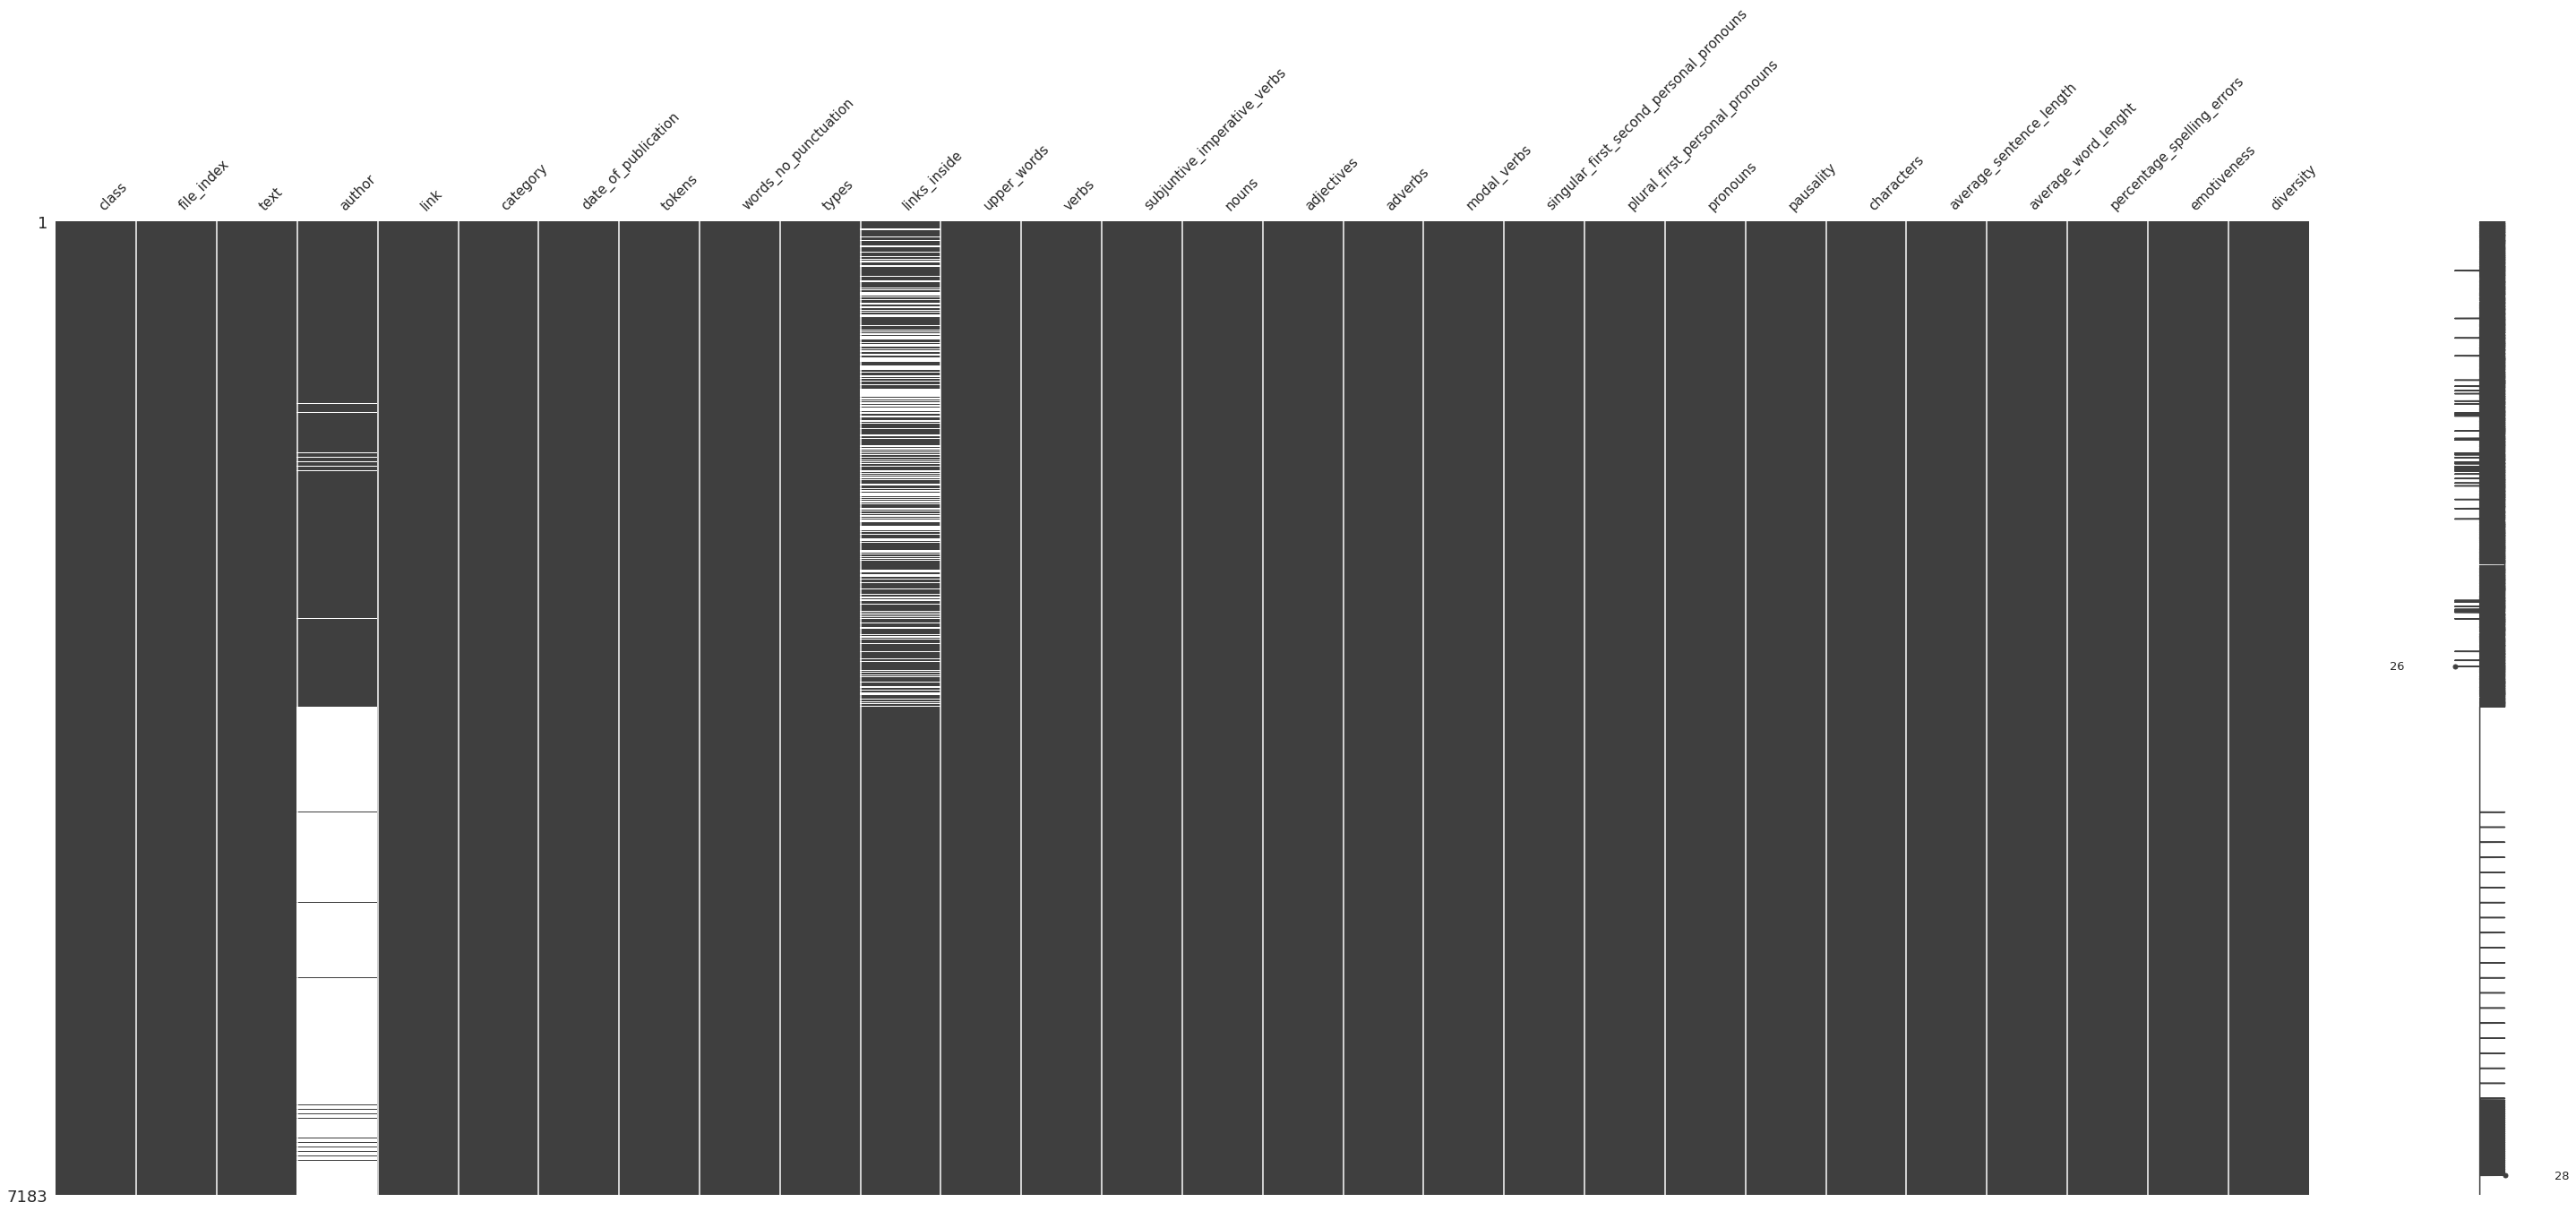

In [24]:
fig = msno.matrix(data_df, figsize=(50, 20), fontsize=15)
fig.get_figure().savefig(REPORTS_PATH / f'missing_values.jpg')

### Authors

Since the data is sorted such as the true news rows are the first ones. Let's analyze the proportion of missing authors of the news based on the class

In [30]:
print(data_df[data_df["class"] == 'True'].author.isna().sum() / len(data_df[data_df["class"] == 'True']))
print(data_df[data_df["class"] == 'Fake'].author.isna().sum() / len(data_df[data_df["class"] == 'Fake']))

0.012838403572425341
0.98


To evaluate if the problem was on the collection or a characteristic of fake news, let's take a look on some links. For example:

In [40]:
data_df[data_df["class"] == 'Fake'].head(10)[["link", "author"]].values

array([['https://ceticismopolitico.com/2017/11/30/katia-abreu-diz-que-vai-colocar-sua-expulsao-em-uma-moldura-mas-nao-para-de-reclamar/',
        'mrk'],
       ['https://ceticismopolitico.com/2017/11/24/dr-ray-peita-bolsonaro-chama-o-de-conservador-fake-em-entrevista-a-danilo-gentili-e-divide-a-direita/',
        nan],
       ['https://afolhabrasil.com.br/politica/reinaldo-azevedo-desmascarado-pela-policia-federal/',
        nan],
       ['https://www.diariodobrasil.org/relatorio-assustador-do-bndes-mostra-dinheiro-publico-do-brasil-jorrando-em-paises-comunistas/',
        nan],
       ['https://www.diariodobrasil.org/radialista-americano-detona-o-pt-a-esquerda-so-vende-ilusao-eles-so-pensam-em-se-divertir-no-sitio/',
        nan],
       ['https://www.diariodobrasil.org/situacao-de-waack-e-mais-grave-do-que-se-pensava-apresentador-continuara-internado-no-sirio-libanes/',
        nan],
       ['https://www.diariodobrasil.org/problema-cardiaco-tira-william-waack-do-jornal-da-globo-apre

Looking at the links above, by the time of this analysis, some of the links are inaccessible and others really does not have authors. Since we don't see a great contribution of this variable we are going to drop it.

In [41]:
data_df = data_df.drop(columns="author")

### Links Inside

Now let's evaluate the variable "links inside". On the plot above we can see that there is a great correlation between real news and absence of links inside.

In [42]:
print(data_df[data_df["class"] == 'True'].links_inside.isna().sum() / len(data_df[data_df["class"] == 'True']))
print(data_df[data_df["class"] == 'Fake'].links_inside.isna().sum() / len(data_df[data_df["class"] == 'Fake']))

0.38598939436226626
0.0


Let's do a manual analysis to evaluate what to do with the links

In [44]:
data_df[(data_df["class"] == 'True') & (data_df["links_inside"].isna())].head(10)[["link", "links_inside"]].values

array([['http://politica.estadao.com.br/blogs/coluna-do-estadao/podemos-expulsa-gaguim-e-abre-espaco-para-katia-abreu/',
        nan],
       ['http://www1.folha.uol.com.br/poder/2018/01/1949909-bolsonaro-e-um-liberal-completo-diz-presidente-do-psl.shtml',
        nan],
       ['https://g1.globo.com/mg/minas-gerais/noticia/stf-suspende-prisao-domiciliar-de-andrea-neves-primo-de-aecio-e-ex-assessor-de-zeze-perrella.ghtml',
        nan],
       ['https://g1.globo.com/resumo-do-dia/noticia/quarta-feira-8-de-fevereiro-de-2017a.ghtml',
        nan],
       ['http://cultura.estadao.com.br/blogs/estado-da-arte/o-interlocutor-fraterno-czeslaw-milosz-escreve-sobre-albert-camus/',
        nan],
       ['https://g1.globo.com/politica/noticia/relatorio-final-de-cpi-recomenda-investigacao-de-rodrigo-janot.ghtml',
        nan],
       ['http://cultura.estadao.com.br/noticias/cinema,mostra-celebra-cinema-de-luis-bunuel-o-mais-iconoclasta-dos-surrealistas,1643518',
        nan],
       ['https://g1.gl

Looking at the links manually some of the news have links inside. The aproach here will be {{...}}

In [46]:
## TODO: Links Inside
# Old: data_df.links_inside = data_df.links_inside.fillna(0)

## Outlier Analysis

### Graphical Analysis

In [47]:
CONTINUOUS_VARIABLES = [x for x, y in data_df.dtypes.iteritems() if str(y) not in ('category', 'object')]

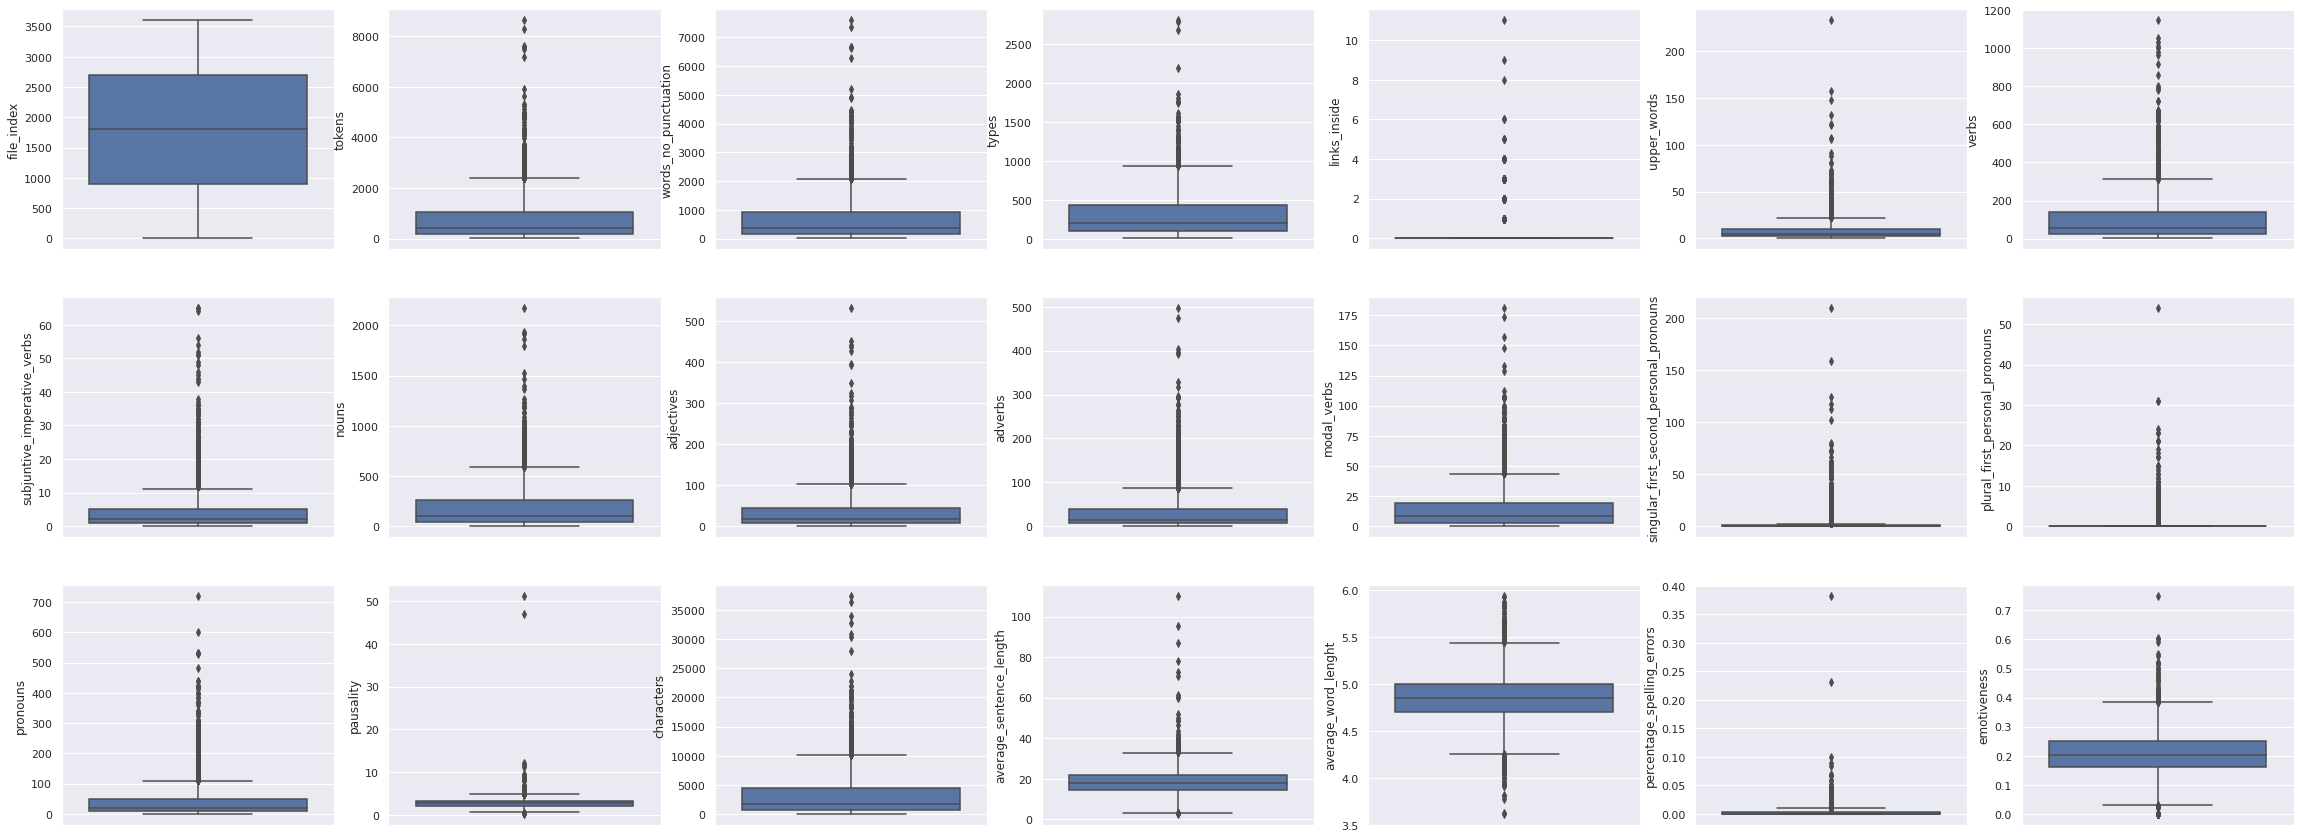

In [54]:
# Box Plot Grid
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(40, 15), sharex=False, sharey=False)
for col, ax in zip(CONTINUOUS_VARIABLES, axes.flat):
    sns.boxplot(y=col, data=data_df[CONTINUOUS_VARIABLES], ax=ax)

if SAVE_FIGURES: plt.savefig(REPORTS_PATH / 'allboxplots.png')
plt.show()

# Individual Plots
if SAVE_FIGURES: 
    SAVEFIG_FOLDER = REPORTS_PATH / "boxplots"
    SAVEFIG_FOLDER.mkdir(exist_ok=True, parents=True)

    for col in CONTINUOUS_VARIABLES:
        fig = plt.figure(figsize=(6,8))
        sns.boxplot(y=col, data=data_df[CONTINUOUS_VARIABLES])
        plt.savefig(SAVEFIG_FOLDER/ f'{col}.png')
        plt.close()

By looking at the box plots above all the variables contains outliers. The approach here is to analyze the ondes that look like erroneous ones. For example, a text with 200 uppercase words or 40% of spelling errors. Let's look at then

In [55]:
def iqr_outlier_finder(df, variable):
    q1 = df[variable].quantile(.25)
    q3 = df[variable].quantile(.75)
    iqr = q3 - q1
    q_hi = q3 + 1.5 * iqr
    q_low = q1 - 1.5 * iqr
    return df[(df[variable] >=  q_hi) | (df[variable] <= q_low)]

#### Upper words

In [58]:
outliers_df = iqr_outlier_finder(data_df, "upper_words").sort_values('upper_words', ascending=False)
print(f'Number of Outliers: {len(outliers_df)}')
outliers_df.head()

Number of Outliers: 534


,class,file_index,text,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity
509,True,1457,cartas pac 2 ano...,http://opiniao.e...,tv_celebridades,01 de abril de ...,7608.0,6674.0,2782.0,0.0,233.0,1002.0,56.0,1863.0,428.0,403.0,108.0,13.0,4.0,482.0,2.54496,33862.0,18.1853,5.07372,0.023524,0.290052,0.41684
3021,True,477,cartas democraci...,http://opiniao.e...,tv_celebridades,25 de março de ...,8279.0,7348.0,2805.0,0.0,157.0,1148.0,64.0,1936.0,452.0,474.0,157.0,19.0,15.0,602.0,2.07812,36369.0,16.4018,4.94951,0.022319,0.300259,0.38173
2589,True,333,cartas apoio a c...,http://opiniao.e...,politica,24 de março de ...,7516.0,6645.0,2680.0,0.0,148.0,1015.0,65.0,1791.0,395.0,392.0,112.0,8.0,9.0,528.0,2.41274,32770.0,18.4072,4.93153,0.021069,0.280470,0.40331
6754,Fake,597,lista dos 29 dep...,https://www.diar...,politica,18/10/2017,534.0,445.0,265.0,0.0,132.0,27.0,4.0,190.0,5.0,9.0,6.0,0.0,0.0,6.0,8.09091,2061.0,40.4545,4.63146,0.000000,0.064516,0.59550
3154,True,597,veja a ordem de ...,http://politica....,politica,01 de agosto de...,3079.0,2003.0,949.0,0.0,122.0,51.0,3.0,1141.0,17.0,26.0,3.0,0.0,0.0,17.0,51.23810,10115.0,95.3810,5.04993,0.000000,0.036074,0.47378


In [59]:
outliers_df.head().link.values

array(['http://opiniao.estadao.com.br/noticias/geral,cartas,532303',
       'http://opiniao.estadao.com.br/noticias/geral,cartas,528953',
       'http://opiniao.estadao.com.br/noticias/geral,cartas,528433',
       'https://www.diariodobrasil.org/lista-dos-29-deputados-da-ccj-que-votaram-pelo-arquivamento-das-denuncias-contra-temer/',
       'http://politica.estadao.com.br/noticias/geral,veja-a-ordem-de-votacao-dos-deputados-a-respeito-da-denuncia,70001918690'],
      dtype=object)

Looking at the links above there are texts that are written as letters that contains lots of uppercase words on the headers and at the end. On the other cases we have abbreviations of the political parties. So, the outliers make sense.

####  Spelling errors

In [61]:
outliers_df = iqr_outlier_finder(data_df, "percentage_spelling_errors").sort_values('percentage_spelling_errors', ascending=False)
print(f'Number of Outliers: {len(outliers_df)}')
outliers_df.head()

Number of Outliers: 611


,class,file_index,text,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity
6836,Fake,670,internauta filma...,https://www.diar...,tv_celebridades,02/10/2017,161.0,136.0,111.0,0.0,0.0,21.0,2.0,58.0,4.0,5.0,2.0,0.0,0.0,11.0,1.666670,597.0,9.06667,4.38971,0.382353,0.113924,0.81617
3236,True,670,nos cometemos er...,https://g1.globo...,tv_celebridades,21/03/2018 16h48,2428.0,2215.0,832.0,0.0,1.0,343.0,43.0,899.0,75.0,95.0,32.0,4.0,6.0,185.0,1.954130,11026.0,20.32110,4.97788,0.231151,0.136876,0.37562
6965,Fake,788,brasileiro que m...,https://www.diar...,tv_celebridades,12/09/2017,29.0,20.0,18.0,1.0,1.0,3.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,1.0,3.000000,107.0,6.66667,5.35000,0.100000,0.100000,0.00000
4591,Fake,1892,midia internacio...,https://www.diar...,sociedade_cotidiano,29/11/2016,202.0,169.0,122.0,0.0,3.0,24.0,3.0,56.0,9.0,4.0,2.0,1.0,0.0,8.0,2.357140,758.0,12.07140,4.48521,0.088757,0.162500,0.72189
6076,Fake,3228,fiocruz alerta q...,https://www.diar...,politica,06/02/2016,14.0,12.0,12.0,0.0,1.0,4.0,0.0,4.0,1.0,0.0,2.0,0.0,0.0,0.0,0.666667,58.0,4.00000,4.83333,0.083333,0.125000,1.00000


In [62]:
outliers_df.head().link.values

array(['https://www.diariodobrasil.org/internauta-filma-homem-flutuando-entre-raios/',
       'https://g1.globo.com/economia/tecnologia/noticia/nos-cometemos-erros-diz-mark-zuckerberg-sobre-escandalo-do-facebook-com-cambridge-analytica.ghtml',
       'https://www.diariodobrasil.org/brasileiro-que-mora-nos-eua-compara-miami-com-rio-de-janeiro-e-texto-viraliza-obrigado-furacao-irma/',
       'https://www.diariodobrasil.org/midia-internacional-destaca-o-vidente-carlinhos-que-supostamente-previu-o-acidente-aereo-de-hoje/',
       'https://www.diariodobrasil.org/fiocruz-alerta-que-virus-zika-pode-ser-transmitido-por-saliva-e-urina/'],
      dtype=object)

The first 4 news contain texts in english that are probably considered spelling errors in portuguese. Let's look at the last case

In [65]:
outliers_df.head().iloc[4].text

'fiocruz alerta que virus zika pode ser transmitido por saliva e urina '

The last case the problem is basically the size of the text and the word "fiocruz" (a brazilian science foundation). So we have $1/12=0.0833$ that is the value shown in the row.

#### Pausality

In [66]:
outliers_df = iqr_outlier_finder(data_df, "pausality").sort_values('pausality', ascending=False)
print(f'Number of Outliers: {len(outliers_df)}')
outliers_df.head()

Number of Outliers: 120


,class,file_index,text,link,category,date_of_publication,tokens,words_no_punctuation,types,links_inside,upper_words,verbs,subjuntive_imperative_verbs,nouns,adjectives,adverbs,modal_verbs,singular_first_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,average_sentence_length,average_word_lenght,percentage_spelling_errors,emotiveness,diversity
3154,True,597,veja a ordem de ...,http://politica....,politica,01 de agosto de...,3079.0,2003.0,949.0,0.0,122.0,51.0,3.0,1141.0,17.0,26.0,3.0,0.0,0.0,17.0,51.2381,10115.0,95.3810,5.04993,0.000000,0.036074,0.47378
1800,True,262,lula tem 34 bols...,https://g1.globo...,politica,2/12/2017,1317.0,801.0,186.0,NaN,15.0,41.0,2.0,352.0,25.0,7.0,1.0,0.0,0.0,18.0,46.9091,3436.0,72.8182,4.28964,0.001248,0.081425,0.23220
4729,Fake,2015,forbes pele figu...,https://www.diar...,tv_celebridades,30/10/2016,226.0,165.0,101.0,0.0,14.0,20.0,0.0,50.0,3.0,4.0,1.0,0.0,0.0,0.0,12.2000,902.0,33.0000,5.46667,0.000000,0.100000,0.61212
5503,Fake,2712,r 11 milhoes do ...,https://www.diar...,tv_celebridades,05/06/2016,252.0,182.0,114.0,0.0,17.0,14.0,0.0,65.0,8.0,3.0,1.0,0.0,0.0,4.0,11.6667,781.0,30.3333,4.29121,0.038462,0.139241,0.62637
6587,Fake,446,lula admite que ...,https://www.diar...,politica,15/12/2017,214.0,180.0,123.0,0.0,3.0,31.0,1.0,45.0,5.0,5.0,5.0,3.0,0.0,16.0,11.3333,759.0,60.0000,4.21667,0.000000,0.131579,0.68333


In [69]:
outliers_df.head().link.values

array(['http://politica.estadao.com.br/noticias/geral,veja-a-ordem-de-votacao-dos-deputados-a-respeito-da-denuncia,70001918690',
       'https://g1.globo.com/politica/noticia/lula-tem-34-bolsonaro-17-e-marina-9-aponta-pesquisa-datafolha-para-2018.ghtml',
       'https://www.diariodobrasil.org/forbes-pele-figura-entre-os-12-atletas-aposentados-mais-bem-pagos-do-mundo/',
       'https://www.diariodobrasil.org/r-11-milhoes-do-nosso-dinheiro-verba-da-petrobras-foi-usada-para-sustentar-sites-petistas/',
       'https://www.diariodobrasil.org/lula-admite-que-sera-condenado-por-novos-crimes-a-pf-e-o-mp-inventam-mentiras/'],
      dtype=object)

The first link is a list of names. Since the pausality variable takes into account the number of dots it makes sense. The other texts have the same idea.

## Exporting Data

In [70]:
PROCESSED_DATA_FOLDER = Path('data/processed/')
PROCESSED_DATA_FOLDER.mkdir(exist_ok=True, parents=True)

data_df.to_csv(PROCESSED_DATA_FOLDER/"fake_true_news_cleaned.csv")